## Libraries

In [1]:
import sys, distutils.core

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

c:\users\hedronstone\desktop\im_segmentation\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import PIL

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/shoes"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

%matplotlib inline 

## Data
Register the dataset to detectron2.

In [3]:
from detectron2.structures import BoxMode

img_dir = "/shoes" # file path

def get_shoes_dicts(img_dir):
  json_file = os.path.join(img_dir, "via_region_data.json")
  # load the json file
  with open(json_file) as f:
    imgs_anns = json.load(f)["_via_img_metadata"]

  dataset_dicts = []
  for idx, v in enumerate(imgs_anns.values()):
    # empty dictionary for...
    record = {}

    filename = os.path.join(img_dir, v["filename"])
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width

    annos = v["regions"]
    objs = []
    for anno in annos:
      anno = anno["shape_attributes"]
      px = anno["all_points_x"]
      py = anno["all_points_y"]
      poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
      poly = [p for x in poly for p in x]

      obj = {
          "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
          "bbox_mode": BoxMode.XYXY_ABS,
          "segmentation": [poly],
          "category_id": 0,
      }

      objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
  return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("shoes_" + d, lambda d=d: get_shoes_dicts("shoes/" + d))
    MetadataCatalog.get("shoes_" + d).set(thing_classes=["shoe"])

shoes_metadata = MetadataCatalog.get("shoes_train")

## Training

In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("shoes_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 600    # 600
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/29 08:50:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[11/29 08:50:06 d2.engine.train_loop]: Starting training from iteration 0
[11/29 08:50:12 d2.utils.events]:  eta: 0:01:31  iter: 19  total_loss: 1.831  loss_cls: 0.5657  loss_box_reg: 0.3061  loss_mask: 0.6926  loss_rpn_cls: 0.1094  loss_rpn_loc: 0.02583  time: 0.1598  data_time: 0.1073  lr: 8.1588e-06  max_mem: 2927M
[11/29 08:50:15 d2.utils.events]:  eta: 0:01:26  iter: 39  total_loss: 1.823  loss_cls: 0.532  loss_box_reg: 0.2212  loss_mask: 0.6794  loss_rpn_cls: 0.2426  loss_rpn_loc: 0.03242  time: 0.1573  data_time: 0.0012  lr: 1.6484e-05  max_mem: 2938M
[11/29 08:50:18 d2.utils.events]:  eta: 0:01:25  iter: 59  total_loss: 1.587  loss_cls: 0.443  loss_box_reg: 0.301  loss_mask: 0.6473  loss_rpn_cls: 0.1372  loss_rpn_loc: 0.02725  time: 0.1589  data_time: 0.0013  lr: 2.4809e-05  max_mem: 2938M
[11/29 08:50:21 d2.utils.events]:  eta: 0:01:23  iter: 79  total_loss: 1.337  loss_cls: 0.3552  loss_box_reg: 0.2483  loss_mask: 0.6232  loss_rpn_cls: 0.05217  loss_rpn_loc: 0.02109  time: 0.

## Inference and Evaluation

In [12]:
from detectron2.engine import DefaultPredictor

cfg = get_cfg() # obtain detectron2's default config
cfg.merge_from_file(r"C:\Users\Hedronstone\Desktop\nike_project\detectron2\pretrained_weights\outputs\output.yaml") # load values from a file
cfg.OUTPUT_DIR = r"C:\Users\Hedronstone\Desktop\nike_project\detectron2\pretrained_weights\outputs" # update output directory
cfg.MODEL.WEIGHTS = r"C:\Users\Hedronstone\Desktop\nike_project\detectron2\pretrained_weights\outputs\model_final.pth" # path to model checkpoint
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

[11/29 09:02:43 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

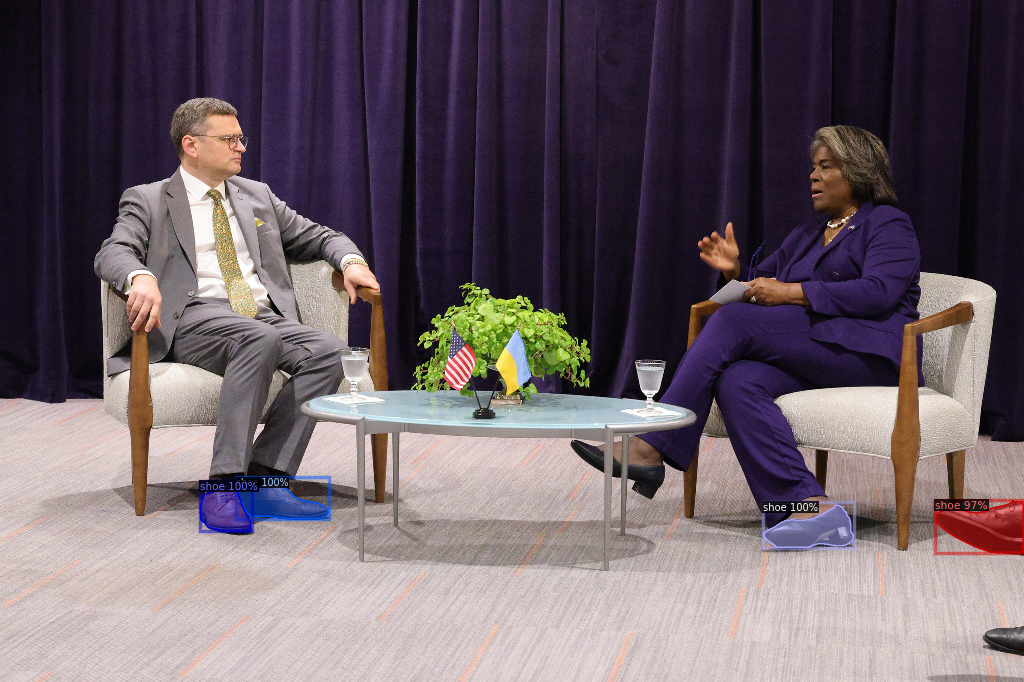

In [13]:
import PIL

# randomly select several samples to visualize the prediction results
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_shoes_dicts("shoes/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=shoes_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
PIL.Image.fromarray(out.get_image())